# Random Forest
Gudenas data

In [1]:
from datetime import datetime
print(datetime.now())

2023-07-13 12:27:52.655187


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/Localization/"

2023-07-13 12:27:52.696394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU device not found
Running on Mac


2023-07-13 12:28:02.119161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from platform import python_version
print('Python',python_version())
import random
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep and time functions
from os.path import isfile
import gzip
from matplotlib import pyplot as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
# consider sklearn.metrics.classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

Python 3.10.0
sklearn 1.1.2


## Data Load

In [4]:
MAX_LINES_TO_LOAD =    10 # use this for debugging
MAX_LINES_TO_LOAD = None

DATA_FILE_0 = 'Gudenas/Gudenas.Supplement.Data1.csv'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)

Data directory: /Users/jasonmiller/WVU/Localization/
Data file 0 Gudenas/Gudenas.Supplement.Data1.csv


In [5]:
class DataLoader():
    def __init__(self,filepath1,verbose=True):
        self.file = filepath1
        self.verbose = verbose
        self.max_lines = None

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def load_full_train_set(self):
        minimum = 0
        max_lines = self.max_lines
        num_lines = 0
        header = None
        self.id = []
        self.fold_change = []
        self.label = []
        self.feature = []
        self.names = []
        try:
            with open(self.file,'r') as fin:
                for line in fin:
                    line=line.strip()
                    fields=line.split(',')
                    if header is None:
                        header = fields
                        self.names.append(fields)
                        continue
                    if max_lines is not None and num_lines >= max_lines:
                        break
                    num_lines += 1
                    # Retain critical info about each sample
                    self.id.append(fields[0])
                    self.fold_change.append(fields[1])
                    if fields[-1] =='Cytosol':
                        self.label.append(0)
                    else:  # Nucleus
                        self.label.append(1)
                    # Zero out columns that give away the answer!
                    fields[0]=0 # ID
                    fields[1]=0 # fold change
                    fields[-1]=0 # cytosol/nucleus label
                    for i in range(len(fields)):
                        #if header[i].startswith('chromosome'):
                        if header[i].isdigit():
                            fields[i] = 0
                    # Change GC content from fraction to percent
                    fields[3]=100.0*float(fields[3])+0.5  
                    # Change all columns to integers
                    ints = list(map(int,fields))
                    self.feature.append(ints)
        except Exception as e:
            print(e)
            raise Exception('CANNOT LOAD DATA FROM FILE!')
            
    def get_names(self):
        return self.names

    def show_examples(self,how_many=3):
        for i in range(how_many):
            print(self.id[i], self.fold_change[i],self.label[i])
            print(self.feature[i])
            #print(self.feature[i][:5],'...',self.feature[i][-5:])

    def get_X_y(self,one_out_of=5):
        ONE_OUT_OF = one_out_of
        length = len(self.label)
        X_train = []
        y_train = []
        X_valid = []
        y_valid = []
        skip = 0
        for i in range(length):
            skip += 1
            if skip == ONE_OUT_OF:
                # Set aside every fifth sample for validation
                X_valid.append(self.feature[i])
                y_valid.append(self.label[i])
                skip = 0
            else:
                X_train.append(self.feature[i])
                y_train.append(self.label[i])
        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        X_valid = np.asarray(X_valid)
        y_valid = np.asarray(y_valid)
        return X_train,y_train, X_valid,y_valid

In [6]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
loader=DataLoader(filepath0)
if MAX_LINES_TO_LOAD is not None:
    loader.set_max_lines(MAX_LINES_TO_LOAD)
print('LOADING...')
loader.load_full_train_set()
print('EXAMPLES:')
loader.show_examples()

2023-07-13 12:28:04.721341
LOADING...
EXAMPLES:
ENST00000446102 -0.521941851 0
[0, 0, 1363, 44, 111, 70, 99, 94, 102, 68, 5, 110, 101, 59, 83, 65, 61, 88, 120, 126, 32, 25, 26, 28, 24, 16, 2, 28, 32, 17, 30, 20, 18, 17, 29, 30, 29, 15, 30, 27, 28, 15, 2, 23, 1, 1, 2, 1, 13, 24, 44, 29, 34, 13, 31, 23, 18, 15, 1, 25, 35, 20, 15, 13, 12, 16, 20, 17, 16, 17, 12, 16, 32, 22, 0, 34, 33, 21, 35, 31, 18, 31, 27, 50, 6, 8, 9, 9, 5, 9, 0, 11, 11, 2, 7, 6, 7, 3, 7, 11, 7, 2, 11, 4, 7, 3, 2, 4, 1, 1, 0, 0, 5, 8, 11, 4, 10, 4, 10, 8, 4, 5, 0, 8, 12, 7, 6, 5, 4, 5, 6, 5, 5, 5, 3, 5, 9, 6, 0, 2, 7, 5, 10, 7, 1, 8, 12, 9, 11, 6, 8, 4, 8, 2, 1, 4, 11, 7, 9, 3, 3, 7, 7, 10, 5, 1, 11, 11, 7, 3, 0, 5, 0, 0, 1, 1, 2, 3, 11, 7, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 5, 2, 4, 2, 7, 6, 0, 11, 17, 6, 13, 8, 5, 6, 4, 14, 9, 8, 7, 10, 4, 1, 1, 7, 8, 6, 10, 7, 6, 5, 8, 4, 5, 4, 4, 5, 11, 1, 0, 3, 0, 0, 1, 0, 4, 6, 10, 5, 12, 3, 12, 8, 7, 5, 1, 7, 7, 3, 1, 4, 3, 1, 6, 3, 3, 5, 2, 2, 7, 3, 0, 6, 6, 3, 5, 

In [7]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))

X train shape: 
(6943, 1585)
y train shape: 
(6943,)
X valid shape: 
(1735, 1585)
y valid shape: 
(1735,)


## Model

In [8]:
def build_model(num_trees=100):
    rfc = RFC(n_estimators=num_trees)
    return rfc

In [9]:
print(datetime.now())
rfc_model=build_model(500)
print(rfc_model)

2023-07-13 12:28:10.145033
RandomForestClassifier(n_estimators=500)


## Training

In [10]:
print(datetime.now())
print("FIT")
start = time.time()
rfc_model.fit(X_train, y_train) 
end = time.time()
print('Elapsed time in sec: ', end-start)
print(datetime.now())

2023-07-13 12:28:10.219369
FIT
Elapsed time in sec:  34.565401792526245
2023-07-13 12:28:44.785601


## Validation

In [11]:
print(datetime.now())
print("PREDICT")
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-07-13 12:28:44.818679
PREDICT
debug pred [0.536, 0.19, 0.588]
debug class [1 0 1]
2023-07-13 12:28:46.022194


In [12]:
# In binary classification, recall of the positive class is also known as “sensitivity”
# and recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [13]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.4977152737752162 mean 0.16740441867546993 std
Range of scores: 0.01 to 0.906
Confusion matrix
 [[586 301]
 [207 641]]
Normalized matrix
 [[0.33775216 0.17348703]
 [0.11930836 0.36945245]]
Predictions:  {0: 793, 1: 942}
Accuracy: 70.72% F1: 71.62% MCC: 0.4180
Precision: 68.05% Recall: 75.59% AUPRC: 75.19%
Sensitivity: 75.59% Specificity: 66.07% AUROC: 78.18%


RF(500) without binding motifs  
Accuracy: 70.72% F1: 71.62% MCC: 0.4180  
Precision: 68.05% Recall: 75.59% AUPRC: 75.19%  
Sensitivity: 75.59% Specificity: 66.07% AUROC: 78.18%  

RF(500) without chromosomes:    
Predictions:  {0: 797, 1: 938}  
Accuracy: 70.26% F1: 71.11% MCC: 0.4085  
Precision: 67.70% Recall: 74.88% AUPRC: 75.51%  
Sensitivity: 74.88% Specificity: 65.84% AUROC: 78.18%  

Default RF:  
Accuracy: 69.68% F1: 70.22% MCC: 0.3957  
Precision: 67.54% Recall: 73.11% AUPRC: 75.13%  
Sensitivity: 73.11% Specificity: 66.40% AUROC: 77.49%  

RF(1000 estimators):  
Accuracy: 70.49% F1: 71.52% MCC: 0.4139  
Precision: 67.68% Recall: 75.83% AUPRC: 75.69%  
Sensitivity: 75.83% Specificity: 65.39% AUROC: 78.11%  

## Feature Importance

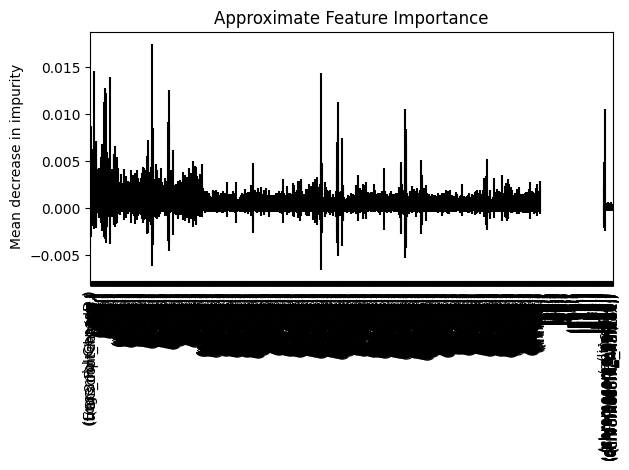

In [14]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
feature_names = loader.get_names()
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    its = forest_importances.sort_values()
    print(its)

Ensembl Gene ID      0.000000
71                   0.000000
70                   0.000000
69                   0.000000
68                   0.000000
67                   0.000000
66                   0.000000
65                   0.000000
64                   0.000000
63                   0.000000
72                   0.000000
62                   0.000000
60                   0.000000
59                   0.000000
58                   0.000000
57                   0.000000
56                   0.000000
55                   0.000000
54                   0.000000
53                   0.000000
52                   0.000000
61                   0.000000
51                   0.000000
73                   0.000000
75                   0.000000
95                   0.000000
94                   0.000000
93                   0.000000
92                   0.000000
91                   0.000000
90                   0.000000
89                   0.000000
88                   0.000000
87        